In [22]:
# Import libraries
!pip install shap
!pip install pandas-gbq
import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.cloud import bigquery 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [23]:
#clgx-surveillance-prd-f609.ampd_02_Cost.02_CostTracking

In [24]:
# Initialize connection 
project = !gcloud config get-value project
project_id = project[0]
bq = bigquery.Client(project = project_id)

In [25]:
project_id

'clgx-surveillance-sbx-f577'

In [26]:
# Read dataset in from Big Query
dataset = 'ltaylor'
table = 'Cost_02_Copy_2'
query = f"""
SELECT * 
FROM `{project_id}.{dataset}.{table}`
"""
df = bq.query(query = query).to_dataframe()
df.head()

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,invoice_date,service_description,sku_description,project_id,business_unit,cost
0,2023-10-19,Cloud Scheduler,Jobs,clgx-surveillance-prd-f609,None,0.002290
1,2023-10-19,Cloud Storage,Upload,clgx-surveillance-reg-ec2c,None,0.000000
2,2023-10-19,BigQuery,Analysis,clgx-surveillance-dr-66e6,None,0.885941
3,2023-10-19,BigQuery,Analysis,clgx-surveillance-reg-ec2c,None,0.002875
4,2023-10-19,BigQuery,Analysis,clgx-surveillance-np-reg-ccfe,None,0.742937


In [27]:
df.sort_values('invoice_date').tail()

,invoice_date,service_description,sku_description,project_id,business_unit,cost
6479,2024-07-06,BigQuery,Long Term Logical Storage,clgx-surveillance-sbx-f577,insuw,1.374001
6478,2024-07-06,BigQuery,Long Term Logical Storage,clgx-surveillance-sbx-f577,imagery,0.000241
6477,2024-07-06,BigQuery,Long Term Logical Storage,clgx-surveillance-sbx-f577,hpi,0.000960
6475,2024-07-06,BigQuery,Long Term Logical Storage,clgx-surveillance-sbx-f577,fraud,0.219790
6437,2024-07-06,BigQuery,Long Term Logical Storage,clgx-surveillance-dev-9e5e,appraisal,2.995160


# EDA/Data Cleaning

In [28]:
# Null values
df.isna().sum()

invoice_date                0
service_description         0
sku_description             0
project_id                  0
business_unit          102902
cost                        0
dtype: int64

In [29]:
df['business_unit'].value_counts()

business_unit
foundation                                  29157
ampd                                        22995
fraud                                       16442
reas                                        10991
avm                                         10412
thvx                                         6811
hpi                                          6240
datasol                                      6044
appraisal                                    5279
insuw                                        4136
lavm                                         4012
scheduled_query                              2960
riskmodel                                    2488
weather                                      2433
imagery                                      2134
locinc                                       2010
csi                                          1744
datasolutions                                1431
hazrisk                                      1366
claims                              

In [30]:
# Value counts by service
df['service_description'].value_counts()

service_description
Cloud Storage                              99434
BigQuery                                   74268
Compute Engine                             22363
Cloud Functions                            19996
Cloud Pub/Sub                              12367
Cloud Logging                              11583
Networking                                  1671
Google Click to Deploy Deep Learning VM     1488
Cloud Scheduler                             1096
Vertex AI                                    963
Notebooks                                    473
Artifact Registry                            468
Deep Learning VM                             276
BigQuery Storage API                         232
Cloud Dataflow                               193
Cloud Build                                  138
Stackdriver Logging                          108
Cloud Machine Learning Engine                 35
Cloud Monitoring                               6
Name: count, dtype: int64

In [31]:
# Number of distinct values in service description
len(df['service_description'].unique())

19

In [32]:
# Top 20 sku description value counts
df['sku_description'].value_counts()[0:20]

sku_description
Standard Storage US Multi-region                                     27584
Long Term Logical Storage                                            22905
Active Logical Storage                                               20481
Download Worldwide Destinations (excluding Asia & Australia)         12463
Long Term Storage                                                    11598
Multi-Region Standard Class A Operations                             10395
Active Storage                                                       10338
Log Volume                                                            8487
Standard Storage US Regional                                          7528
Nearline Storage US Multi-region                                      7058
Analysis                                                              6662
Coldline Storage US Multi-region                                      6318
Invocations                                                           5631
CPU Time 

In [33]:
# Number of distinct values in sku description
len(df['sku_description'].unique())

241

In [34]:
# Project id value counts
df['project_id'].value_counts()

project_id
clgx-surveillance-sbx-f577       71857
clgx-surveillance-dev-9e5e       66886
clgx-surveillance-prd-f609       44418
clgx-surveillance-prf-ad2a       16453
clgx-surveillance-dr-66e6        10092
clgx-surveillance-int-4316        9866
clgx-surveillance-reg-ec2c        7764
clgx-surveillance-np-reg-ccfe     4343
clgx-surveillance-sc-prd-3310     4282
clgx-surveillance-uat-bf45        4056
clgx-surveillance-sc-sbx-750d     2959
clgx-surveillance-sc-dev-28c2     1662
clgx-surveillance-poc-b10b        1329
clgx-surveillance-sc-uat-2408     1191
Name: count, dtype: int64

In [35]:
# Number of distinct values in project_id
len(df['project_id'].unique())

14

In [36]:
# Sum of cost by service description
group_df = df.groupby('service_description')['cost'].sum().sort_values(ascending = False)
group_df

service_description
Cloud Storage                              1.266210e+06
BigQuery                                   8.445416e+05
Compute Engine                             1.592325e+04
Cloud Functions                            4.812418e+03
Notebooks                                  7.995840e+02
Cloud Dataflow                             9.795310e+01
Cloud Machine Learning Engine              4.258576e+01
Vertex AI                                  3.642636e+01
BigQuery Storage API                       3.387617e+01
Networking                                 2.838438e+01
Cloud Pub/Sub                              2.979392e+00
Cloud Scheduler                            2.427564e+00
Artifact Registry                          8.044750e-01
Cloud Build                                2.856660e-01
Cloud Monitoring                           5.600000e-05
Deep Learning VM                           0.000000e+00
Google Click to Deploy Deep Learning VM    0.000000e+00
Cloud Logging               

In [37]:
# Average cost
np.mean(df['cost'])

8.628216411582873

In [38]:
df = df.sort_values('invoice_date').reset_index()

In [39]:
df['invoice_date'] = df['invoice_date'].astype(str)

In [40]:
df[(df['business_unit'] == 'thvx')&(df['project_id'] == 'clgx-surveillance-int-4316')&(df['sku_description'] == 'Analysis')].sort_values('cost',ascending = False)[0:25]

,index,invoice_date,service_description,sku_description,project_id,business_unit,cost
227266,155607,2024-04-30,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,425.210448
229529,131604,2024-05-08,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,268.319511
241805,134252,2024-06-19,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,265.622755
220022,25047,2024-04-03,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,259.783660
239482,171003,2024-06-12,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,256.598838
223770,246799,2024-04-17,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,256.585861
233631,141657,2024-05-22,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,256.581757
235426,112133,2024-05-29,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,256.558405
226151,2105,2024-04-26,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,256.556807
231265,17500,2024-05-14,BigQuery,Analysis,clgx-surveillance-int-4316,thvx,256.546789


In [41]:
df[(df['business_unit'] == 'thvx')&(df['project_id'] == 'clgx-surveillance-int-4316')]['sku_description'].value_counts()

sku_description
Active Logical Storage       551
Long Term Logical Storage    544
Active Storage               175
Long Term Storage            148
CPU Time                      46
Invocations                   46
Memory Time                   46
Analysis                      22
Name: count, dtype: int64

# Feature Engineering

In [42]:
# Create rolling median feature
date_sum = df.groupby('invoice_date')['cost'].sum()
roll_med = date_sum.rolling(window=30, min_periods=1).median() 

In [43]:
roll_med

invoice_date
2021-07-05       0.000000
2021-07-06       0.000000
2021-07-07       0.000000
2021-07-08     137.251428
2021-07-09     274.502856
                 ...     
2024-07-02    2705.065888
2024-07-03    2695.193089
2024-07-04    2685.036556
2024-07-05    2650.971725
2024-07-06    2618.451714
Name: cost, Length: 1098, dtype: float64

In [44]:
# If cost greater than rolling median 1 else 0
df['greater_than'] = [1 if (df['cost'][i]) > roll_med[df['invoice_date'][i]] and roll_med[df['invoice_date'][i]] > 200 else 0 for i in range(len(df))]

In [45]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [46]:
df['invoice_date'].unique()

<DatetimeArray>
['2021-07-05 00:00:00', '2021-07-06 00:00:00', '2021-07-07 00:00:00',
 '2021-07-08 00:00:00', '2021-07-09 00:00:00', '2021-07-10 00:00:00',
 '2021-07-11 00:00:00', '2021-07-12 00:00:00', '2021-07-13 00:00:00',
 '2021-07-14 00:00:00',
 ...
 '2024-06-27 00:00:00', '2024-06-28 00:00:00', '2024-06-29 00:00:00',
 '2024-06-30 00:00:00', '2024-07-01 00:00:00', '2024-07-02 00:00:00',
 '2024-07-03 00:00:00', '2024-07-04 00:00:00', '2024-07-05 00:00:00',
 '2024-07-06 00:00:00']
Length: 1098, dtype: datetime64[ns]

In [47]:
stats.zscore(list(df['cost']))

array([-0.12130122, -0.12130122, -0.12130122, ..., -0.12128772,
       -0.11821126, -0.07919326])

In [48]:
df[(df['invoice_date'] == '2024-06-24') & (df['cost'] >= 1000)]

,index,invoice_date,service_description,sku_description,project_id,business_unit,cost,greater_than
243425,46759,2024-06-24,Cloud Storage,Coldline Storage US Multi-region,clgx-surveillance-dr-66e6,None,1312.913462,0


In [49]:
df['weekday'] = df['invoice_date'].dt.weekday

In [50]:
# One-hot encode columns
enc_df = df.copy()
enc_df = pd.get_dummies(enc_df)
enc_df.head()

,index,invoice_date,cost,greater_than,weekday,service_description_Artifact Registry,service_description_BigQuery,service_description_BigQuery Storage API,service_description_Cloud Build,service_description_Cloud Dataflow,...,business_unit_riskmodel,business_unit_rqe,business_unit_scheduled_query,business_unit_spatial,business_unit_tax,business_unit_template_example,business_unit_test,business_unit_thvx,business_unit_weather,business_unit_wildfire
0,244200,2021-07-05,0.0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,244202,2021-07-05,0.0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,244203,2021-07-05,0.0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,244204,2021-07-05,0.0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,244205,2021-07-05,0.0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
#cols = ['invoice_date','cost','greater_than','business_unit_thvx','service_description_BigQuery','service_description_Cloud Storage','project_id_clgx-surveillance-sbx-f577','project_id_clgx-surveillance-dr-66e6','project_id_clgx-surveillance-int-4316',
                #'sku_description_Coldline Storage US Multi-region','sku_description_Standard Storage US Multi-region', 'sku_description_Active Logical Storage','sku_description_Analysis',
                 #'sku_description_Long Term Logical Storage', 'sku_description_Nearline Storage US Multi-region' , 'sku_description_Archive Storage US Multi-region']

In [52]:
# Keep invoice_date, cost, along with Projects and sku's asscoiated with high costs
cols =['invoice_date','cost','greater_than','weekday','business_unit_thvx','service_description_BigQuery','service_description_Cloud Storage','project_id_clgx-surveillance-sbx-f577','project_id_clgx-surveillance-dr-66e6','project_id_clgx-surveillance-int-4316',
                'sku_description_Coldline Storage US Multi-region','sku_description_Standard Storage US Multi-region', 'sku_description_Active Logical Storage','sku_description_Analysis',
                 'sku_description_Long Term Logical Storage', 'sku_description_Nearline Storage US Multi-region' , 'sku_description_Archive Storage US Multi-region']
enc_df = enc_df[cols]
enc_df.head()

,invoice_date,cost,greater_than,weekday,business_unit_thvx,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region
0,2021-07-05,0.0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False
1,2021-07-05,0.0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False
2,2021-07-05,0.0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False
3,2021-07-05,0.0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False
4,2021-07-05,0.0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False


In [53]:
# Make columns binary (1,0)
for i in enc_df.drop(columns = ['cost','invoice_date','weekday'], axis = 1).columns:
    enc_df[i] = np.where(enc_df[i] == True, 1,0)
enc_df.head()

,invoice_date,cost,greater_than,weekday,business_unit_thvx,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region
0,2021-07-05,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2021-07-05,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2021-07-05,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2021-07-05,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2021-07-05,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [54]:
# Shape of df 
enc_df.shape

(247158, 17)

In [55]:
# Create features from invoice_date
#enc_df['invoice_date'] = pd.to_datetime(enc_df['invoice_date'],format='%m-%d-%Y')
#enc_df['invoice_day'] = enc_df['invoice_date'].dt.day
#enc_df['invoice_month'] = enc_df['invoice_date'].dt.month
#enc_df.head()

In [56]:
# Save invoice_dates
dates = enc_df['invoice_date']

# Drop invoice date column
enc_df.drop(labels = 'invoice_date', axis = 1, inplace = True)

# Shuffle dataset 
enc_df = enc_df.sample(frac = 1, random_state = 24)

# Initial Model Training 

In [57]:
# Train model with no hyperparameter tuning for baseline, output values. Negtive scores = anomaly, print confidence scores
model = IsolationForest(random_state = 24)
pred = model.fit_predict(enc_df)
prob_scores = abs(model.score_samples(enc_df))

In [58]:
# Create df copy to hold predictions and results
df_pred = enc_df.copy()
df_pred['invoice_date'] = dates
df_pred['label'] = pred
df_pred['prob_score'] = prob_scores

In [59]:
# Percent of data points detected as anomalies
df_pred['label'].value_counts(normalize = True)

label
 1    0.816122
-1    0.183878
Name: proportion, dtype: float64

In [60]:
# Max and average confidence score
anomalies = df_pred[df_pred['label'] == -1]

print('Average Confidence Score: ',anomalies['prob_score'].mean())
print('Max Confidence Score: ',max(anomalies['prob_score']))

Average Confidence Score:  0.5573915270603926
Max Confidence Score:  0.7251245514577208


### Overall the model seems to be misclassifying normal points as anomalous. Around 23% of data points were classified as anomalous. 
### When looking at probability scores the average value for predicted anomalies was around 0.55. This means that confidence in labels was low. Results indicate the need for hyper parameter tuning especially of contamination.

In [61]:
anomalies[anomalies['greater_than'] >= 1]

,cost,greater_than,weekday,business_unit_thvx,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region,invoice_date,label,prob_score
1062,3736.617216,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,2021-07-13,-1,0.565709
833,568.950055,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2021-07-12,-1,0.552246
37638,1881.664441,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,2022-02-09,-1,0.562122
6515,2500.082166,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,2021-08-17,-1,0.565709
53591,10640.141818,1,4,0,1,0,0,0,1,0,0,0,1,0,0,0,2022-04-29,-1,0.701704
53340,1493.783871,1,3,0,1,0,0,0,1,0,0,0,1,0,0,0,2022-04-28,-1,0.695001
30662,867.729143,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,2022-01-04,-1,0.554525
23850,1882.409771,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2021-11-29,-1,0.575605
23915,778.330776,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-11-30,-1,0.532511
22775,13494.209137,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,2021-11-24,-1,0.562122


In [62]:
# Plot feature importance of first high confidence prediction using SHAP
#high_conf_2 = high_conf.drop(labels = ['invoice_date','label','prob_score'], axis = 1)
#explainer = shap.TreeExplainer(model,high_conf_2)
#shap_values = explainer(high_conf_2)
#shap.plots.waterfall(shap_values[0], max_display=16)

In [63]:
# Plot another prediction
#shap.plots.waterfall(shap_values[4], max_display=16)

In [64]:
# Overall plot
#explainer = shap.TreeExplainer(model,X_train)
#shap_values = explainer(X_train)
#shap.summary_plot(shap_values, X_train)

In [65]:
# Overall plot
#explainer = shap.TreeExplainer(model,X_train)
#shap_values = explainer(X_train)
#shap.summary_plot(shap_values, X_train,plot_type = bar)

# Hyperparameter Tuning

In [66]:
# Borrowing some code from:
# https://campus.datacamp.com/courses/anomaly-detection-in-python/isolation-forests-with-pyod?ex=9

# Instantiate and train model using defined hyperparameters, return data classified as inliers 
def eval_IF(c,n_est,max_samp,max_feat,data):
    IF = IsolationForest(contamination = c, n_estimators = n_est, 
        max_samples = max_samp, max_features = max_feat,random_state = 24)
    labels = IF.fit_predict(data)
    df_res = data.copy()
    df_res['labels'] = labels
    return df_res[df_res['labels'] == 1]

# Create and train linear regression using clasisfied inliers, return RMSE
def eval_reg(data):
    X = data.drop(labels = 'cost', axis = 1)
    y = data['cost']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)
    line_reg = LinearRegression()
    y_pred = line_reg.predict(X_test)
    RMSE = mean_squared_error(y_test,y_pred, squared = False)
    return RMSE

In [67]:
# Hyperparameters to chose from 
#contamination = [0.01,0.05]
#n_estimators = [100,150,200]
#max_samples = [0.6,0.8]
#max_features =  [0.6,0.8]

# All different permutations of values
#param_values = [[i,j,k,l] for i in contamination
     #for j in n_estimators
     #for k in max_samples
     #for l in max_features]

#print('Number of Unique Permutations: ', len(param_values))

In [68]:
# Grid search for best hyperparameters
enc_df2 = enc_df.copy()
#scores = dict()
#for i in param_values:
        #inlier_data = eval_IF(c = i[0], n_est = i[1], max_samp = i[2], max_feat = i[3],data = enc_df2)
        #rmse = eval_reg(data = inlier_data)
        # Append scores to dictionary
       # scores[str(i)] = rmse
        

In [69]:
# Best hyperparameters
#min_error = max(scores, key=scores.get)
#print(min_error,abs(scores[min_error]))

In [70]:
# Train model with best hyperparameters
tune_model = IsolationForest(contamination = 0.000075,n_estimators = 150,max_samples = 0.6, max_features = 0.6,random_state = 24)
labels_2 = tune_model.fit_predict(enc_df2)
prob_scores = abs(tune_model.score_samples(enc_df2))

In [71]:
# Percentage of points classified as anomalous
df_res = enc_df2.copy()
df_res['label'] = labels_2
df_res['label'].value_counts(normalize = True)

label
 1    0.999923
-1    0.000077
Name: proportion, dtype: float64

In [72]:
df_res['label'].value_counts()

label
 1    247139
-1        19
Name: count, dtype: int64

In [73]:
# Average and max confidence score
df_res['prob_score'] = prob_scores
df_res['invoice_date'] = dates
df_res = df_res.sort_values('invoice_date')
anomalies = df_res[df_res['label'] == -1]
print('Average Confidence Score: ',anomalies['prob_score'].mean())
print('Max Confidence Score: ',max(anomalies['prob_score']))

Average Confidence Score:  0.7043806914059548
Max Confidence Score:  0.7818445401606866


In [74]:
false_neg = df_res[(df_res['invoice_date'] == '2024-06-24')&(df_res['cost'] >= 1000)]

In [75]:
anomalies.reset_index(inplace = True, drop = True)

In [76]:
anomalies

,cost,greater_than,weekday,business_unit_thvx,service_description_BigQuery,service_description_Cloud Storage,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-dr-66e6,project_id_clgx-surveillance-int-4316,sku_description_Coldline Storage US Multi-region,sku_description_Standard Storage US Multi-region,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Archive Storage US Multi-region,label,prob_score,invoice_date
0,568.950055,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.691493,2021-07-12
1,3736.617216,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.724488,2021-07-13
2,712.021707,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.682014,2021-07-14
3,2500.082166,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.714788,2021-08-17
4,1170.287398,1,2,0,0,1,0,1,0,0,0,0,0,0,0,0,-1,0.693571,2021-10-06
5,13494.209137,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.746668,2021-11-24
6,1882.409771,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.705975,2021-11-29
7,796.588335,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,-1,0.670972,2021-11-30
8,778.330776,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0.665436,2021-11-30
9,2298.741823,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,-1,0.710327,2021-12-15


In [78]:
explainer = shap.TreeExplainer(tune_model)
shap_values = explainer.shap_values(anomalies.drop(labels = ['label','prob_score','invoice_date'],axis = 1)) 
shap_obj = explainer(anomalies.drop(labels = ['label','prob_score','invoice_date'],axis = 1))

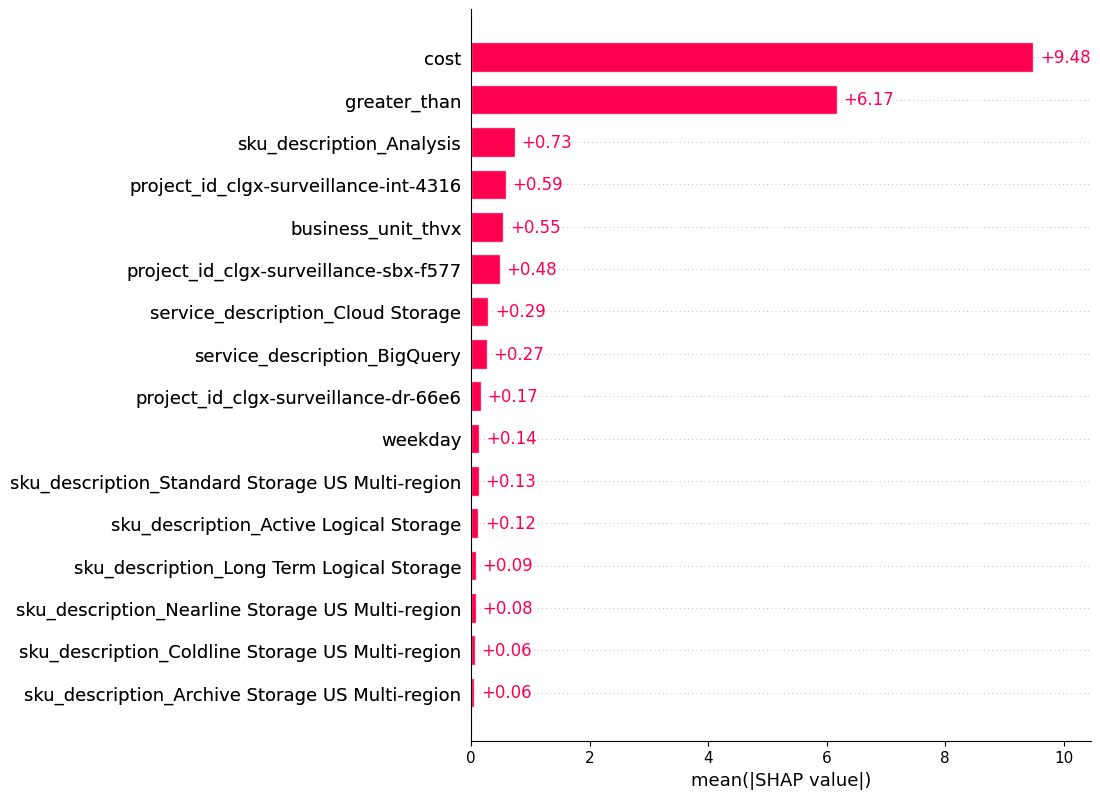

In [79]:
shap.plots.bar(shap_obj,max_display = 17)                    

In [ ]:
shap.waterfall_plot(shap_obj[16],max_display = 17)

In [ ]:
shap.waterfall_plot(shap_obj[17],max_display = 17)

In [ ]:
shap.waterfall_plot(shap_obj[18],max_display = 17)

In [ ]:
df_res[(df_res['business_unit_thvx'] == 1)&(df_res['sku_description_Analysis'] == 1)].sort_values('cost',ascending = False)[0:25]

In [ ]:
df_res[df_res['invoice_date'] == '2024-6-24'].sort_values('cost',ascending = False)[0:25]

In [ ]:
shap_values1 = explainer.shap_values(false_neg.drop(labels = ['label','prob_score','invoice_date'],axis = 1)) 
shap_obj1 = explainer(false_neg.drop(labels = ['label','prob_score','invoice_date'],axis = 1))
shap.waterfall_plot(shap_obj1[0],max_display = 17)

In [ ]:
df_res.head()

In [ ]:
# If confidence >= 68% label = -1
vis_df = df.copy()
vis_df = vis_df.sort_values('invoice_date')
vis_df['prob_score'] = df_res['prob_score']
vis_df['label'] = df_res['label']
#labels = []
#for i in vis_df['prob_score']:
    #if i >= 0.68:
        #labels.append(-1)
    #else:
        #labels.append(1)
#vis_df['labels'] = labels
#vis_df.head()

In [ ]:
vis_df.head()

In [ ]:
vis_df[vis_df['label'] == -1]

In [ ]:
vis_df['labels'].value_counts(normalize = True)

In [ ]:
anom = vis_df[vis_df['labels'] == -1]
anom['service_description'].value_counts()

In [ ]:
# Percentage of anomalies
vis_df['labels'].value_counts(normalize = True)

In [ ]:
# Upload to BQ
vis_df.to_gbq('ltaylor.vis_df2', 
                 project_id, 
                 chunksize=None, 
                 if_exists='replace')